In [17]:
import pandas as pd
import tensorflow as tf
import keras as ks
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import time
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Flatten, ConvLSTM2D, Reshape, Dropout, Activation
from keras.callbacks import ModelCheckpoint
from datetime import datetime



In [24]:
# Load the data
df_train = pd.read_csv('../../data/cleaned/site1_vineyard.csv')
df_train.head()


,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,4.4,1.3,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,4.2,1.2,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,4.3,1.3,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,4.5,1.3,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,4.5,1.3,89.8,9.02,0.4


In [25]:
df_test = pd.read_csv('../../data/cleaned/site2_bird.csv')
df_test.head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.37,2184,-100.0,8.41,10.70,2.7,0.7,92.2,9.16,0.1
1,5/5/2017,0:15,15.45,2139,-101.0,8.43,9.92,2.7,0.7,93.3,9.25,0.1
2,5/5/2017,0:30,15.49,2057,-102.3,8.45,8.90,2.8,0.7,94.8,9.40,0.2
3,5/5/2017,0:45,15.67,1978,-102.6,8.45,8.62,2.7,0.7,96.0,9.49,0.2
4,5/5/2017,1:00,15.34,2136,-100.2,8.41,9.88,2.6,0.7,92.7,9.22,0.1


In [27]:
rfu_ugl_ratio = 1/0.2334
df_train['bga (ug/L)'] = df_train['BGA-Phycocyanin RFU'].apply(
    lambda x : x * rfu_ugl_ratio)
df_train.head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,bga (ug/L)
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,4.4,1.3,90.2,9.04,0.4,1.713796
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,4.2,1.2,90.2,9.04,0.4,1.713796
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,4.3,1.3,90.1,9.04,0.4,1.713796
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,4.5,1.3,90.0,9.03,0.4,1.713796
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,4.5,1.3,89.8,9.02,0.4,1.713796


In [28]:
df_test['bga (ug/L)'] = df_test['BGA-Phycocyanin RFU'].apply(
    lambda x : x * rfu_ugl_ratio)
df_test.head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,bga (ug/L)
0,5/5/2017,0:00,15.37,2184,-100.0,8.41,10.70,2.7,0.7,92.2,9.16,0.1,0.428449
1,5/5/2017,0:15,15.45,2139,-101.0,8.43,9.92,2.7,0.7,93.3,9.25,0.1,0.428449
2,5/5/2017,0:30,15.49,2057,-102.3,8.45,8.90,2.8,0.7,94.8,9.40,0.2,0.856898
3,5/5/2017,0:45,15.67,1978,-102.6,8.45,8.62,2.7,0.7,96.0,9.49,0.2,0.856898
4,5/5/2017,1:00,15.34,2136,-100.2,8.41,9.88,2.6,0.7,92.7,9.22,0.1,0.428449


In [30]:
# Merge time units
df_train['time'] = pd.to_datetime(
    df_train['Date (mm.dd.yyyy)'] + ' '+ df_train['Time 24hr'])
df_train.head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,bga (ug/L),time
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,4.4,1.3,90.2,9.04,0.4,1.713796,2017-05-05 00:00:00
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,4.2,1.2,90.2,9.04,0.4,1.713796,2017-05-05 00:15:00
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,4.3,1.3,90.1,9.04,0.4,1.713796,2017-05-05 00:30:00
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,4.5,1.3,90.0,9.03,0.4,1.713796,2017-05-05 00:45:00
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,4.5,1.3,89.8,9.02,0.4,1.713796,2017-05-05 01:00:00


In [31]:
df_test['time'] = pd.to_datetime(
    df_test['Date (mm.dd.yyyy)'] + ' '+ df_test['Time 24hr'])
df_test.head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,bga (ug/L),time
0,5/5/2017,0:00,15.37,2184,-100.0,8.41,10.70,2.7,0.7,92.2,9.16,0.1,0.428449,2017-05-05 00:00:00
1,5/5/2017,0:15,15.45,2139,-101.0,8.43,9.92,2.7,0.7,93.3,9.25,0.1,0.428449,2017-05-05 00:15:00
2,5/5/2017,0:30,15.49,2057,-102.3,8.45,8.90,2.8,0.7,94.8,9.40,0.2,0.856898,2017-05-05 00:30:00
3,5/5/2017,0:45,15.67,1978,-102.6,8.45,8.62,2.7,0.7,96.0,9.49,0.2,0.856898,2017-05-05 00:45:00
4,5/5/2017,1:00,15.34,2136,-100.2,8.41,9.88,2.6,0.7,92.7,9.22,0.1,0.428449,2017-05-05 01:00:00


In [34]:
# dont need data and time now that we have Timestamp. Lets remove them

df_train = df_train.drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
df_test = df_test.drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])

KeyError: "['Date (mm.dd.yyyy)' 'Time 24hr'] not found in axis"

In [35]:
print(df_train.dtypes)
df_test.dtypes

Temp C                        float64
Sp Cond (uS/cm)                 int64
pH (mV)                       float64
pH                            float64
Turbidity (NTU)               float64
Chlorophyll (ug/L)            float64
Chlorophyll RFU               float64
ODOSat%                       float64
ODO (mg/L)                    float64
BGA-Phycocyanin RFU           float64
bga (ug/L)                    float64
time                   datetime64[ns]
dtype: object


Temp C                        float64
Sp Cond (uS/cm)                 int64
pH (mV)                       float64
pH                            float64
Turbidity (NTU)               float64
Chlorophyll (ug/L)            float64
Chlorophyll RFU               float64
ODOSat%                       float64
ODO (mg/L)                    float64
BGA-Phycocyanin RFU           float64
bga (ug/L)                    float64
time                   datetime64[ns]
dtype: object

In [36]:
df_train['Sp Cond (uS/cm)'] = df_train['Sp Cond (uS/cm)'].astype('float64')
df_test['Sp Cond (uS/cm)'] = df_test['Sp Cond (uS/cm)'].astype('float64')
print(df_train.dtypes)
df_test.dtypes

Temp C                        float64
Sp Cond (uS/cm)               float64
pH (mV)                       float64
pH                            float64
Turbidity (NTU)               float64
Chlorophyll (ug/L)            float64
Chlorophyll RFU               float64
ODOSat%                       float64
ODO (mg/L)                    float64
BGA-Phycocyanin RFU           float64
bga (ug/L)                    float64
time                   datetime64[ns]
dtype: object


Temp C                        float64
Sp Cond (uS/cm)               float64
pH (mV)                       float64
pH                            float64
Turbidity (NTU)               float64
Chlorophyll (ug/L)            float64
Chlorophyll RFU               float64
ODOSat%                       float64
ODO (mg/L)                    float64
BGA-Phycocyanin RFU           float64
bga (ug/L)                    float64
time                   datetime64[ns]
dtype: object

In [15]:
# lets try to normalize this now....
from sklearn.preprocessing import MinMaxScaler
dataset_columns = ['Temp C','Sp Cond (uS/cm)', 'pH (mV)','pH', 'Turbidity (NTU)', 'ODOSat%','ODO (mg/L)']
scaler = MinMaxScaler()
ds_scaled = scaler.fit_transform(dataset[dataset_columns])
dataset = pd.DataFrame(ds_scaled,columns=dataset_columns)
dataset.describe()


,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L)
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,0.560516,0.893366,0.477889,0.541089,0.090355,0.165126,0.273546
std,0.267413,0.070246,0.116241,0.113254,0.085879,0.093899,0.116220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.308195,0.853771,0.426166,0.461538,0.045893,0.117086,0.190000
50%,0.640366,0.895882,0.492228,0.553846,0.065216,0.138870,0.264545
75%,0.784656,0.956502,0.538860,0.592308,0.102407,0.177672,0.370909
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Visualizing the data

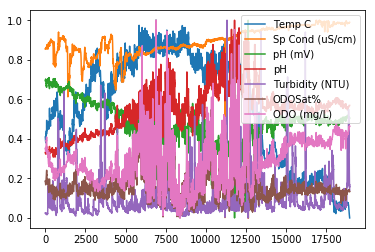

In [18]:
dataset.plot.line()

# Breaking apart training and test data

In [18]:

x_train, x_test, y_train, y_test = train_test_split(segments, labels, test_size=0.1, random_state=42)

In [19]:
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

NameError: name 'x_train' is not defined

# RNN Model

In [28]:
#Build the model
input_shape = (9, 7)
conv_output_shape = (1, 7, 1, 44)

model = Sequential()

model.add(LSTM(NUM_CLASSES, dropout=0.2, input_shape=input_shape))
model.add(Reshape((1, 2)))
model.add(LSTM(NUM_CLASSES, dropout=0.2))
model.add(Reshape((1, 2)))
model.add(LSTM(NUM_CLASSES, dropout=0.2))
Dense(NUM_CLASSES, activation='softmax', input_dim=2)
model.compile(loss=ks.losses.categorical_crossentropy,
        optimizer=ks.optimizers.Adam(lr=0.0001),
        metrics=['accuracy'])
model.build()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 2)                 80        
_________________________________________________________________
reshape_4 (Reshape)          (None, 1, 2)              0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 2)                 40        
_________________________________________________________________
reshape_5 (Reshape)          (None, 1, 2)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 2)                 40        
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
17044/17044 [==============================] - 17s 1ms/step - loss: nan - acc: 0.9952
Epoch 2/100
17044/17044 [================

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [ ]:
# Train the model
model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)


In [ ]:
# Evaluate the results
score = model.evaluate(x_train, y_train, verbose=1)
predictions = model.predict(x_test)
predict = create_class_predictions(predictions)
recall = recall_score(y_test.reshape(-1,), predict)
print("RECALL:",recall)

## Save the model for deployment

In [ ]:
# ignoring dropout for deployment
K.set_learning_phase(0)
 
# Set a file path to save the model in.
model_name = "rnn_prediction_model"
model_version = "1"
tf_path = "./../../saved_models/{}/{}".format(model_name, model_version)
 
# Get the session from the Keras back-end to save the model in TF format.
with K.get_session() as sess:
    tf.saved_model.simple_save(sess, tf_path, inputs={'input': model.input}, outputs={t.name: t for t in model.outputs})
